# **Методы машинного обучения. Лабораторная работа №3**
# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

**Задание:**


1.   Выбрать набор данных (датасет), содержащий категориальные признаки и пропуски в данных. Для выполнения следующих пунктов можно использовать несколько различных наборов данных (один для обработки пропусков, другой для категориальных признаков и т.д.)
2.   Для выбранного датасета (датасетов) на основе материалов лекции решить следующие задачи:


*   обработку пропусков в данных;
*    кодирование категориальных признаков;
*    масштабирование данных.

**Выполнение:**



In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ММО/3/hotel_bookings.csv', sep=",")
data.shape

(119390, 32)

In [0]:
for col in data.columns:
  print(col)

hotel
is_canceled
lead_time
arrival_date_year
arrival_date_month
arrival_date_week_number
arrival_date_day_of_month
stays_in_weekend_nights
stays_in_week_nights
adults
children
babies
meal
country
market_segment
distribution_channel
is_repeated_guest
previous_cancellations
previous_bookings_not_canceled
reserved_room_type
assigned_room_type
booking_changes
deposit_type
agent
company
days_in_waiting_list
customer_type
adr
required_car_parking_spaces
total_of_special_requests
reservation_status
reservation_status_date


In [0]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


Вывод колонок, содержащих нулевые значения (данные отображены в процентном соотношении)



> Обработка пропусков данных





In [0]:
# функция просмотра переменных с процентным соотношением пустых наблюдений в ней
def getColumnsWithEmptyCells(dataToPrepare, printFlag=True ): 
  percentOfMissingValues = round(dataToPrepare.isnull().sum() / len(dataToPrepare) * 100 , 2)
  percentOfMissingValues = percentOfMissingValues[percentOfMissingValues > 0]
  columnTypes = pd.Series(data[percentOfMissingValues.index.values].dtypes)
  if(printFlag):
    print(pd.DataFrame(data= np.c_[percentOfMissingValues, columnTypes], columns=['Missing %', 'Type'], index= [percentOfMissingValues.index.values]))
  return percentOfMissingValues.index.values

dataEmptyCells = getColumnsWithEmptyCells(data)

        Missing %     Type
country      0.41   object
agent       13.69  float64
company     94.31  float64




---



1.   Удаление пустых колонок/строк




In [0]:
data1 = data.dropna(axis='columns')
(data1.shape, data.shape)

((119390, 28), (119390, 32))

Отказаться от трех переменных - не такая плохая идея


In [0]:
data2 = data.dropna(axis='rows', how='all')
data3 = data.dropna(axis='rows')
data4 = data.dropna(axis='rows', thresh=2)
print('Original data: ', data.shape, '\nData without ALL empty rows', data2.shape, 
      '\nData without rows with empty cells', data3.shape,'\nData without rows with 2 empty cells', data4.shape)

Original data:  (119390, 32) 
Data without ALL empty rows (119390, 32) 
Data without rows with empty cells (217, 32) 
Data without rows with 2 empty cells (119390, 32)


Ввиду того, что переменная *company* содержит 94% пропусков, отказываться от всех строк с пропусками нет никакого смысла - останется менее 4% от всей выборки

In [0]:
dataWithoutCountries =  data.dropna(subset=['country'])
print(dataWithoutCountries.shape)
noEmptyCountriesData = getColumnsWithEmptyCells(dataToPrepare= dataWithoutCountries)

(118902, 32)
        Missing %     Type
agent       13.46  float64
company     94.43  float64


Однако, отказаться от наблюдений переменной, содержащей низкий процент нулевых значений, будет действительно хорошей идеей

In [0]:
dataFillCountry = data.fillna(0)
getColumnsWithEmptyCells(dataFillCountry)

Empty DataFrame
Columns: [Missing %, Type]
Index: []


array([], dtype=object)

Вариант с заменой всех пустых значений на 0 будет не лучшей идеей, так как одна из колонок с пропусками имела нечисловой тип данных



---


2.   Импьютация данных



*   Обработка пропусков в числовых данных




In [0]:
emptycols = getColumnsWithEmptyCells(dataToPrepare= dataWithoutCountries, printFlag= False)
data_num = data[emptycols]
data_num

,agent,company
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,304.0,NaN
4,240.0,NaN
...,...,...
119385,394.0,NaN
119386,9.0,NaN
119387,9.0,NaN
119388,89.0,NaN


Необходимо построить гистограммы для того, чтобы ознакомиться с распределением переменных, имеющих пропуски в наблюдениях


In [0]:
for col in data_num:
  fig = px.histogram(data_frame= pd.DataFrame(data = data[col]), x=col, height= 300)  
  fig.show()

Приступим к замене значений в переменной *agent*

In [0]:
data1 = dataWithoutCountries
# Выведем индексы наблюдений с пустыми ячейками в переменной agent
agentEmptyIndeces = data1[data1['agent'].isnull()].index
agentEmptyIndeces

Int64Index([     0,      1,      2,      6,     18,     32,     42,     55,
                56,     58,
            ...
            119117, 119118, 119119, 119122, 119123, 119124, 119151, 119166,
            119215, 119248],
           dtype='int64', length=16006)

Выведем наблюдения с пустыми значениями в переменной *agent*

In [0]:
agentEmptyObs = data1[data1.index.isin(agentEmptyIndeces)]
agentEmptyObs.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NaN,NaN,0,Transient,107.00,0,0,Check-Out,2015-07-03
18,Resort Hotel,0,0,2015,July,27,1,0,1,2,0.0,0,BB,FRA,Corporate,Corporate,0,0,0,A,G,0,No Deposit,NaN,110.0,0,Transient,107.42,0,0,Check-Out,2015-07-02


In [0]:
agentEmptyObs['agent'].value_counts()

Series([], Name: agent, dtype: int64)

Для выполнения импьютации необходимо подключить SimpleImputer из библиотеки sklearn

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

Собираем массив с флагами отсутствующих значений

In [0]:
indicator = MissingIndicator()
data1[['agent']]
maskMissingValuesOnly = indicator.fit_transform(data1[['agent']])
maskMissingValuesOnly

array([[ True],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

Функция для использования *SimpleImputer'a*. В качестве аргумента - показатель центра распределения

In [0]:
def testImpute(strat):
  imputer= SimpleImputer(strategy= strat)
  data_num_imp= imputer.fit_transform(data1[['agent']])
  return data_num_imp[maskMissingValuesOnly]


*   Среднее значение


In [0]:
testImpute('mean')

array([86.54407363, 86.54407363, 86.54407363, ..., 86.54407363,
       86.54407363, 86.54407363])



*   Медиана



In [0]:
testImpute('median')

array([14., 14., 14., ..., 14., 14., 14.])


*   Мода


In [0]:
testImpute('most_frequent')

array([9., 9., 9., ..., 9., 9., 9.])



*   Обработка пропусков в категориальных данных

Обратимся к начальному датасету повторно




In [0]:
getColumnsWithEmptyCells(data)

        Missing %     Type
country      0.41   object
agent       13.69  float64
company     94.31  float64


array(['country', 'agent', 'company'], dtype=object)

Из всех переменных только `country` является типом *object*

In [0]:
data['country'].value_counts()

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
MDG        1
BFA        1
LCA        1
BDI        1
FJI        1
Name: country, Length: 177, dtype: int64

In [0]:
dataMFImpute = data
imputer = SimpleImputer(strategy='most_frequent')
dataMFImpute['country'] = imputer.fit_transform(dataMFImpute[['country']])
getColumnsWithEmptyCells(dataMFImpute)

        Missing %     Type
agent       13.69  float64
company     94.31  float64


array(['agent', 'company'], dtype=object)

In [0]:
dataConstImpute = data
imputer= SimpleImputer( missing_values=np.nan,  strategy='constant', fill_value='!!!')
changedCol = imputer.fit_transform( dataConstImpute[['country']])
changedCol

array([['PRT'],
       ['PRT'],
       ['GBR'],
       ...,
       ['DEU'],
       ['GBR'],
       ['DEU']], dtype=object)

In [0]:
changedCol[changedCol == '!!!'].size

488

3. Преобразование категориальных признаков в числовые



In [0]:
# Переменная категориального типа данных
# Необходимо перевести все данные в str
CountryColumn = data.country.astype('str')

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [0]:
le = LabelEncoder()
countryVar_le = le.fit(CountryColumn)
countryVar_le.classes_

array(['ABW', 'AGO', 'AIA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM',
       'ATA', 'ATF', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA',
       'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB',
       'BWA', 'CAF', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL',
       'COM', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI',
       'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH',
       'FIN', 'FJI', 'FRA', 'FRO', 'GAB', 'GBR', 'GEO', 'GGY', 'GHA',
       'GIB', 'GLP', 'GNB', 'GRC', 'GTM', 'GUY', 'HKG', 'HND', 'HRV',
       'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR',
       'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KIR',
       'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBY', 'LCA', 'LIE', 'LKA',
       'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDG', 'MDV', 'MEX',
       'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ', 'MRT', 'MUS', 'MWI',
       'MYS', 'MYT', 'NAM', 'NCL', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL',
       'NZL', 'OMN', 

In [0]:
transformed = countryVar_le.transform(CountryColumn)
transformed

array([135, 135,  59, ...,  43,  59,  43])

In [0]:
le.inverse_transform([0,1,2,3,4,5])

array(['ABW', 'AGO', 'AIA', 'ALB', 'AND', 'ARE'], dtype=object)

Onehot кодирование



In [0]:
pd.get_dummies(CountryColumn, dummy_na=True).head()

,ABW,AGO,AIA,ALB,AND,ARE,ARG,ARM,ASM,ATA,ATF,AUS,AUT,AZE,BDI,BEL,BEN,BFA,BGD,BGR,BHR,BHS,BIH,BLR,BOL,BRA,BRB,BWA,CAF,CHE,CHL,CHN,CIV,CMR,CN,COL,COM,CPV,CRI,CUB,...,QAT,ROU,RUS,RWA,SAU,SDN,SEN,SGP,SLE,SLV,SMR,SRB,STP,SUR,SVK,SVN,SWE,SYC,SYR,TGO,THA,TJK,TMP,TUN,TUR,TWN,TZA,UGA,UKR,UMI,URY,USA,UZB,VEN,VGB,VNM,ZAF,ZMB,ZWE,NaN
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


В результате получаем таблицу, схожую по своей сути с матрицей смежности: 
в строках содержатся нули и единицы, обозначающие наличие категории в оригинальной таблице




3.   Масштабирование данных 



*    MinMax масштабирование



In [0]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

In [0]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['lead_time']])

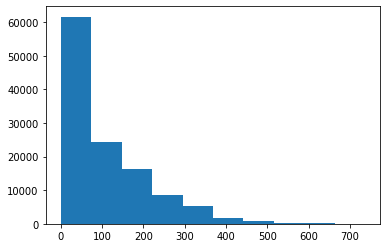

In [0]:
plt.hist(data.lead_time)
plt.show()

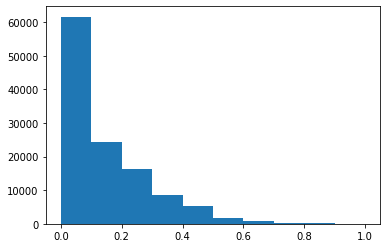

In [0]:
plt.hist(sc1_data)
plt.show()



*   Масштабирование данных на основе Z-оценки



In [0]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['lead_time']])

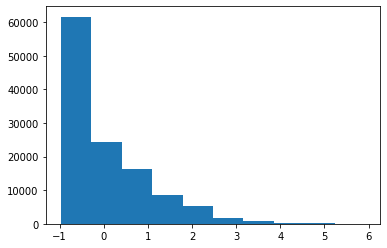

In [0]:
plt.hist(sc2_data)
plt.show()



*   Нормализация данных



In [0]:
sc3 = Normalizer()
sc3_data = sc3.fit_transform(data[['lead_time']])

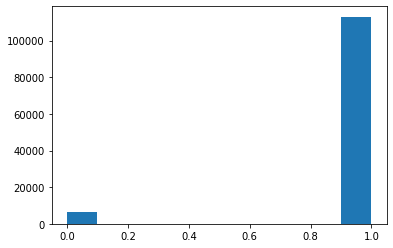

In [0]:
plt.hist(sc3_data)
plt.show()